##### Import

In [1]:
from astropy.io import fits
import os
import numpy as np
import matplotlib.pyplot as plt
# import pickle

In [ ]:
from simple_veloce_reduction import veloce_config, veloce_reduction_tools, veloce_extraction, veloce_wavecalib

### Set up
It is done outside of my extraction function

In [ ]:
# use config as always but just for the single arm as the notebook is not set up to run 'all'

In [3]:
config = {
    # primary information for the reduction
    'reduce': 'run',  # what to reduce options: 'run', 'night', or 'file'
    'date': '230826',  # date of the observation (YYMMDD), if 'reduce' is 'night' or 'file'
    'filename': '26aug20146.fits',  # name of the file to reduce, if 'reduce' is 'file'
    'science_targets': 'targets.dat',  # file containing a list of science targets
    'calib_type': 'SimLC',  # Wavelength calibration to use SimLC, SimThXe (not implemented), Interpolate_lc (LC not implemented), Interpolate_th (Th, not implemented), or Static
    # secondary information for the reduction
    'use_log': True,  # True or False, if True the code will use the log files to identify the files
    'arm': 'green',  # Which arm to reduce 'all', 'red', 'green' or 'blue'
    'amplifier_mode': 4,  # 2 or 4
    'validate_trace': True,  # True or False, if True the code will cross-correlate FibFlat with reference to determine offset of the trace(s)
    'sim_calib': True,  # Flag indicating if the simultaneous calibration was used True or False
    'plot_diagnostic': True,  # True or False
    'scattered_light': True,  # try to remove scattered light (background) True or False
    'flat_field': True,  # these are fiber flats (white light fiber spectrum) used for pixel sensitivity True or False

    # part responsible for the paths
    'input_dir': 'Data/Raw/CSV_Run',  # path to the directory with data (the input directory should include subdirectories for nights)
    'output_dir': 'Data/Extracted/Step-by-step',  # path to the directory where extracted data will be stored (i.e. output directory)

    # below are paths where code will store intermediate files and diagnostics
    # by default they are set as subdirectories of output directory with extracted data
    'master_dir': 'Default',  # directory for master images for night/run
    'wavelength_calibration_dir': 'Default',  # directory for wavelength calibration related files for the night/run
    'trace_shift_dir': 'Default',  
    'plot_dir': 'Default',  # directory for diagnostic plots

    # below are paths where the code will look for internal files
    # leave as default unless you know what you are doing
    'trace_dir': 'Default',  # path to the directory with traces to be extracted
    'trace_file': 'Default',  # filename of the file with traces to be extracted
    'wave_dir': 'Default',  # path to the directory with reference wavelength solution
}

# veloce_paths = veloce_config.VelocePaths.from_config(config)
science_targets = veloce_config.load_target_list(config['science_targets'])

##### Directory structure <br>
It helps me pass all the paths between compnents but is less relevant in this step-by-step deminstration.<br>
I'm not quite happy of my approach to it but I hope it works.

In [4]:
veloce_paths = veloce_config.VelocePaths.from_config(config)

In [5]:
obs_list = veloce_config.load_night_logs(
            science_targets, veloce_paths, config)

### Begining of data extraction

All below happens in the extraction function:


In [6]:
# select correct dir name based on arm
arm = config['arm']
if arm == 'blue':
    ccd = 'ccd_1'
elif arm == 'green':
    ccd = 'ccd_2'
elif arm == 'red':
    ccd = 'ccd_3'
else:
    raise ValueError('Unsupported arm')

Traces based on calibration fiber traces for ThAr from the manual to extract all expected orders. <br>
Position for the run is validated against a template from community science verification run.

In [7]:
trace_filename = os.path.join(veloce_paths.trace_dir, f'veloce_{arm}_4amp_sim_calib_trace.pkl')
traces = veloce_reduction_tools.Traces.load_traces(trace_filename)

In [8]:
### check if the trace needs to be updated (i.e. it was derived for different date and the phisical position on the detector changed)
if config['validate_trace']:
    # load fiber flat for trace validation
    traces = veloce_extraction.get_trace_shift(traces, veloce_paths, arm, config['amplifier_mode'], config['sim_calib'], obs_list)

[Info]: No trace shift detected, not adjusting traces.


In [9]:
# load spectrum
spectrum_filename = os.path.join(veloce_paths.input_dir, config['date'], ccd, config['filename'])
with fits.open(spectrum_filename) as hdul:
    image_data = hdul[0].data
    hdr = hdul[0].header

Removing overscan bias and merging the four quadrants.<br>

In [10]:
image_subtracted_bias = veloce_reduction_tools.remove_overscan_bias(image_data, hdr, arm, config['amplifier_mode'], overscan_range=32)

In [11]:
%matplotlib inline

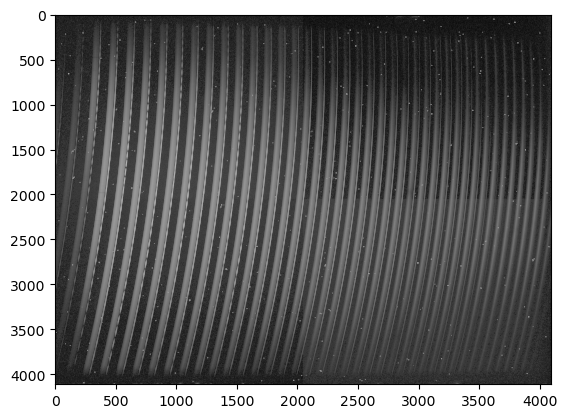

In [12]:
plt.close('all')
plt.imshow(image_subtracted_bias, aspect='auto', cmap='gray', norm='symlog')
plt.show()

Extracting orders based on the loaded traces.<br>
Below is a plot from my examination tool presenting cross section of extracted order. The extracted data is sum of counts from region between dashed lines (exclusive). I'm not ploting anything during bulk reduction.

In [13]:
if config['flat_field']:
    flat, norm_flat = veloce_extraction.get_flat(veloce_paths, arm, config['amplifier_mode'], config['date'], obs_list)
    image_subtracted_bias, hdr = veloce_reduction_tools.flat_field_correction(image_subtracted_bias, norm_flat, hdr)

In [14]:
if config['scattered_light']:
    image_subtracted_bias, hdr = veloce_extraction.remove_scattered_light(image_subtracted_bias, hdr, traces)

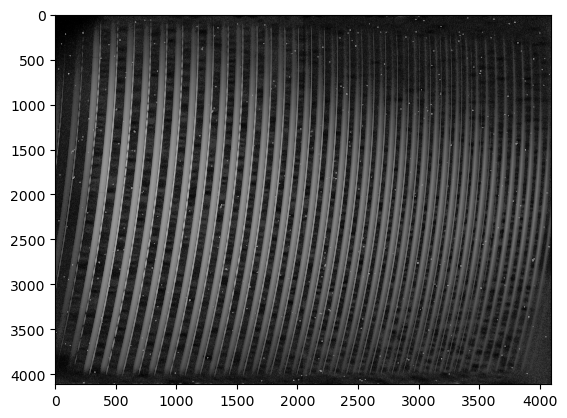

In [15]:
plt.close('all')
plt.imshow(image_subtracted_bias, aspect='auto', cmap='gray', norm='symlog')
plt.show()

In [16]:
extracted_science_orders, extracted_order_imgs = veloce_reduction_tools.extract_orders_with_trace(
        image_subtracted_bias, traces, remove_background=False)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.95809209, 0.        , 4.325489  , ..., 8.90173814, 5.38799874,
        0.        ],
       [3.53752448, 3.69703635, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.3534261 , 1.35330099, ..., 0.        , 0.85048098,
        1.55319517]])

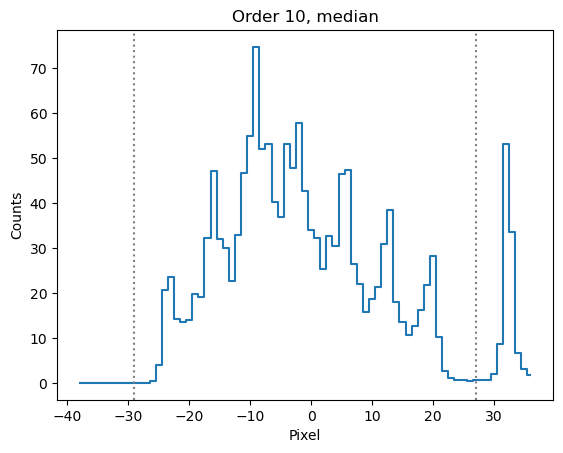

In [17]:
order = 10
veloce_reduction_tools.plot_order_cross_section(image_subtracted_bias, traces, order)

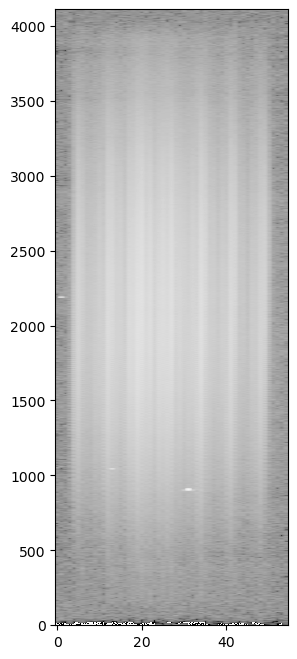

In [18]:
order = 10
fig = plt.figure(figsize=(3, 8))
plt.imshow(extracted_order_imgs[order], aspect='auto', cmap='gray', norm='log', origin='lower')

Wave calibration based on the precomputed solution from Chris. There is one order offset between my traces and wave solutions (it is incomplete order and should be removed from traces for final version).

In [19]:
if config['calib_type'] == 'Static':
    # load static wave calibration based on ThAr (from Chris Tinny)
    ORDER, COEFFS, MATCH_LAM, MATCH_PIX, MATCH_LRES, GUESS_LAM, Y0 = veloce_reduction_tools.load_prefitted_wave(
        arm=arm, wave_calib_slice=traces.wave_calib_slice, wave_path=veloce_paths.wave_dir)
    vacuum_wave = veloce_reduction_tools.calibrate_orders_to_wave(extracted_science_orders, Y0, COEFFS, traces=traces)                   
    final_flux = extracted_science_orders
    final_wave = [veloce_reduction_tools.vacuum_to_air(wave) for wave in vacuum_wave]
elif config['calib_type'] == 'SimLC':
    vacuum_wave, final_flux = veloce_wavecalib.calibrate_simLC(
                extracted_science_orders, veloce_paths, image_subtracted_bias,
                hdr, arm, plot=config['plot_diagnostic'])
    final_wave = [veloce_reduction_tools.vacuum_to_air(wave) for wave in vacuum_wave]
elif config['calib_type'] == 'arcTh':
    final_wave = veloce_wavecalib.calibrate_absolute_Th(
        traces, veloce_paths, obs_list,
        config['date'], arm, config['amplifier_mode'],
        plot=config['plot_diagnostic'], plot_filename='step-by-step',
        th_linelist_filename='Default')
    final_flux = extracted_science_orders
else:
    raise ValueError('Unsupported calibration type')



[Warning]: Reference LC and extracted LC do not have the same number of orders.
Amplitude: 3538358997.2092886
 Shift: -0.020938434024234398
 Sigma: 0.8033340313786745
 Beta: 1.9244580314662274
 Baseline: 241351495.5946137
Calibration Precision estimated at 511nm: 0 m/s


In [21]:
# filename = os.listdir(veloce_paths.output_dir)[0]
# wave, flux, hdr = veloce_reduction_tools.load_extracted_spectrum_fits(os.path.join(veloce_paths.output_path, filename))

Text(0, 0.5, 'Flux [ADU]')

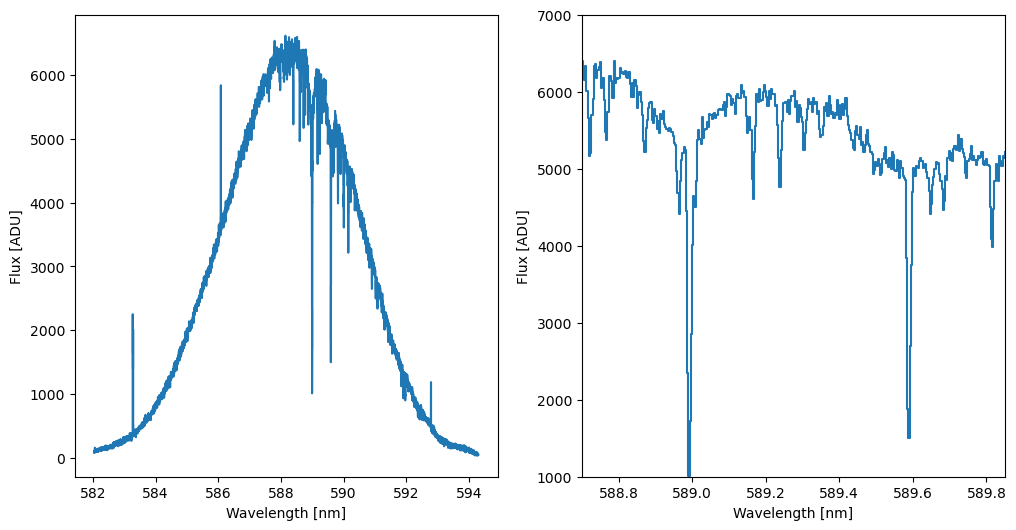

In [20]:
order = 1
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].step(final_wave[order], final_flux[order], where='mid')
ax[0].set_xlabel('Wavelength [nm]')
ax[0].set_ylabel('Flux [ADU]')
ax[1].step(final_wave[order], final_flux[order], where='mid')
plt.xlim(588.7, 589.85)
plt.ylim(1000, 7000)
ax[1].set_xlabel('Wavelength [nm]')
ax[1].set_ylabel('Flux [ADU]')

In [21]:
# save extracted spectrum as fits file
fits_filename = os.path.join(veloce_paths.output_dir, f"veloce_{arm}_{config['filename']}")
veloce_reduction_tools.save_extracted_spectrum_fits(
    filename=fits_filename, wave=final_wave, flux=final_flux, hdr=hdr)

'/home/usqobserver2/Joachim_veloce/veloce_reduction_dev/veloce_reduction/Data/Extracted/Step-by-step/veloce_green_26aug20146.fits'